# 9회차: CNN을 활용한 패션 아이템 분류 (3) - 모델 학습 및 평가

## 8회차 데이터 전처리

In [ ]:
# 필수 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서플로우 및 케라스 API 불러오기
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import confusion_matrix, classification_report

# 1 데이터 로딩 및 전처리
# Fashion MNIST 데이터셋 로딩 (훈련 데이터와 테스트 데이터 분리 제공됨)
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 픽셀 값을 0~255 정수에서 0~1 실수로 정규화 (모델 성능 향상)
x_train = x_train / 255.0
x_test = x_test / 255.0

# CNN 입력 형식에 맞게 채널 차원 추가: (28, 28) → (28, 28, 1)
x_train = x_train[..., np.newaxis]  # shape: (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # shape: (10000, 28, 28, 1)

# 클래스(레이블)에 해당하는 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## CNN 모델 구현

In [5]:
# 필수 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서플로우 및 케라스 API 불러오기
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import confusion_matrix, classification_report

In [9]:
# 1 데이터 로딩 및 전처리
# Fashion MNIST 데이터셋 로딩 (훈련 데이터와 테스트 데이터 분리 제공됨)
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 픽셀 값을 0~255 정수에서 0~1 실수로 정규화 (모델 성능 향상)
x_train = x_train / 255.0
x_test = x_test / 255.0

# CNN 입력 형식에 맞게 채널 차원 추가: (28, 28) → (28, 28, 1)
x_train = x_train[..., np.newaxis]  # shape: (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # shape: (10000, 28, 28, 1)

# 클래스(레이블)에 해당하는 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# 2 CNN 모델 구성
# 순차적인 모델로 구성: Conv2D → MaxPooling → Conv2D → MaxPooling → Flatten → Dense → Output
model = models.Sequential([
    Input(shape=(28, 28, 1)),                      # 명시적 입력 레이어 추가
    layers.Conv2D(32, (3, 3), activation='relu'),  # 첫 번째 컨볼루션 층: 32개의 3x3 필터
    layers.MaxPooling2D((2, 2)),                   # 2x2 풀링으로 다운샘플링
    layers.Conv2D(64, (3, 3), activation='relu'),  # 두 번째 컨볼루션 층: 64개의 필터
    layers.MaxPooling2D((2, 2)),                   # 2x2 풀링
    layers.Flatten(),                              # 다차원 특징 맵을 1차원 벡터로 평탄화
    layers.Dense(64, activation='relu'),           # 은닉층: 64개의 뉴런
    layers.Dense(10, activation='softmax')         # 출력층: 10개의 클래스 확률
])

# 2-1 모델 구조 요약 출력
print("CNN 모델 구조 요약:")
model.summary()  # 각 층의 출력 형태 및 파라미터 수를 출력

CNN 모델 구조 요약:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
import numpy as np
from tensorflow.keras.activations import softmax

logits = np.array([1.0, 5.0, 3.0, 2.0])
probs = softmax(logits).numpy()
probs  # 예: [0.02, 0.83, 0.11, 0.04]

array([0.01521943, 0.83095266, 0.11245721, 0.0413707 ])

## CNN 모델 학습

In [12]:
# 3 모델 컴파일 및 학습
# 손실 함수: sparse_categorical_crossentropy (정수형 라벨 사용)
# 옵티마이저: Adam (적응적 학습률 사용)
# 평가지표: accuracy (정확도)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습: 훈련 데이터 중 10%를 검증 데이터로 사용 (validation_split=0.1)
history = model.fit(x_train, y_train, epochs=20, validation_split=0.1)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7613 - loss: 0.6593 - val_accuracy: 0.8785 - val_loss: 0.3365
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8792 - loss: 0.3281 - val_accuracy: 0.8860 - val_loss: 0.3098
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8983 - loss: 0.2761 - val_accuracy: 0.8940 - val_loss: 0.2821
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9118 - loss: 0.2428 - val_accuracy: 0.9002 - val_loss: 0.2731
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9250 - loss: 0.2049 - val_accuracy: 0.9110 - val_loss: 0.2503
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9322 - loss: 0.1870 - val_accuracy: 0.9103 - val_loss: 0.2447
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9356 - loss: 0.1683 - val_accuracy: 0.9082 - val_loss: 0.2531
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9439 - loss: 0.1502

## CNN 성능 검증

In [13]:
%config InlineBackend.figure_format = 'retina'

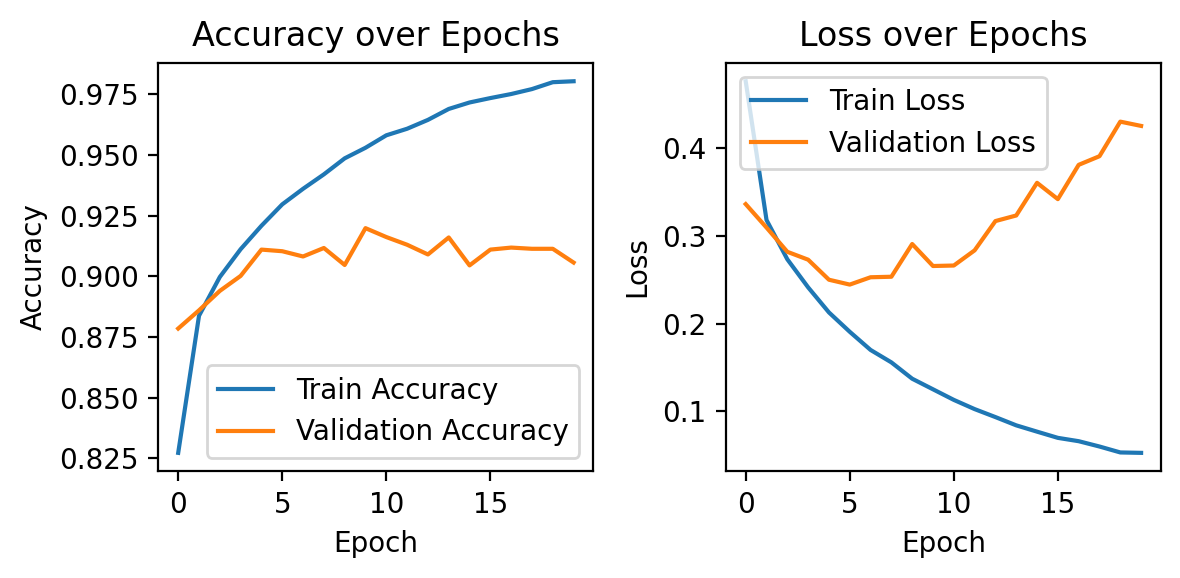

In [14]:
# 3-1 학습 정확도 및 손실 그래프 시각화
plt.figure(figsize=(6, 3))

# 정확도 변화 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')          # 훈련 정확도
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # 검증 정확도
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실값 변화 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')                  # 훈련 손실
plt.plot(history.history['val_loss'], label='Validation Loss')         # 검증 손실
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## CNN 평가

In [16]:
# 4 모델 평가 (테스트 데이터)
# 학습되지 않은 테스트 데이터로 모델 정확도 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\n[테스트 정확도]: {test_acc:.4f}')

313/313 - 1s - 2ms/step - accuracy: 0.9046 - loss: 0.4646

[테스트 정확도]: 0.9046


In [17]:
# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(x_test)                        # softmax 확률 출력
y_pred_classes = np.argmax(y_pred, axis=1)            # 확률이 가장 높은 클래스 선택

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


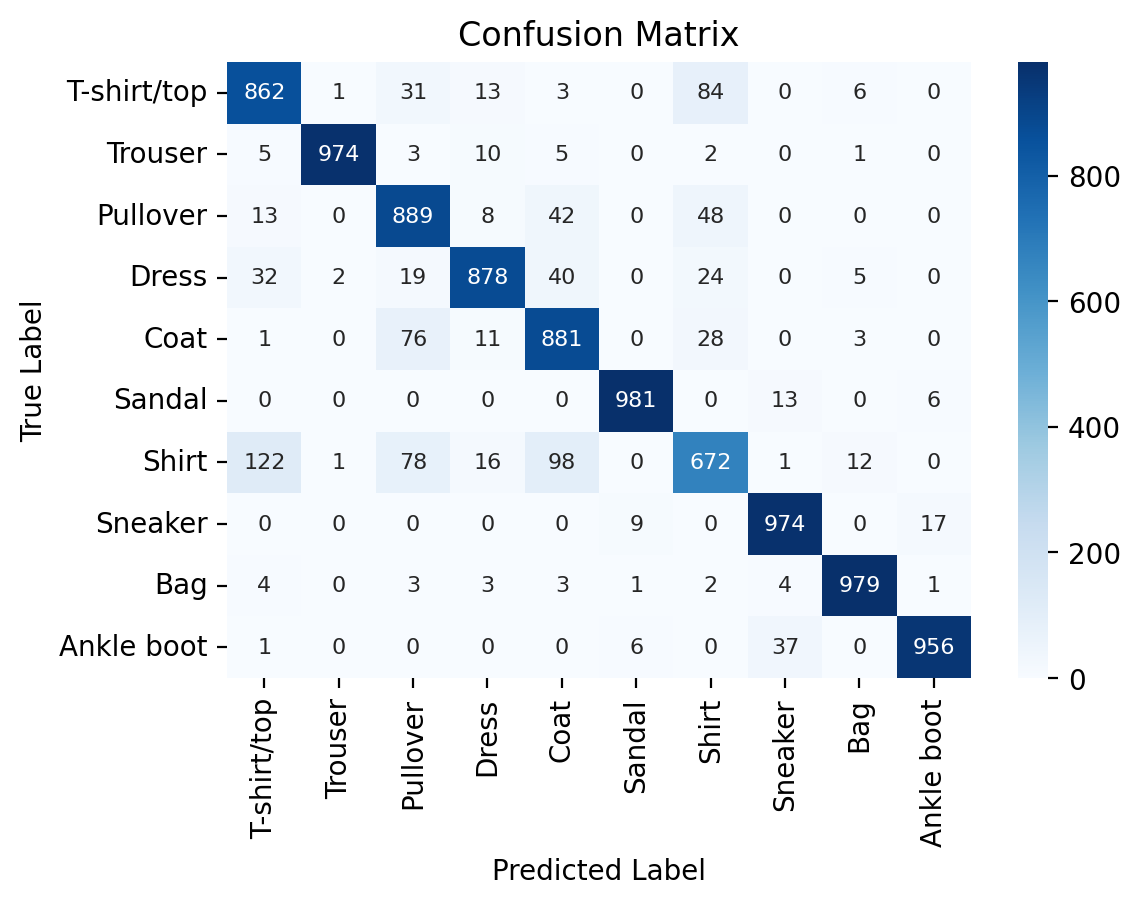

In [18]:
# 4-1 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_classes)         # 혼동 행렬 계산

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 8})  # ← 폰트 크기 조정
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [23]:
# 4-2 분류 리포트 출력 (정확도, 정밀도, 재현율, F1-score)
print("분류 리포트:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

분류 리포트:
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.86      0.85      1000
     Trouser       1.00      0.97      0.98      1000
    Pullover       0.81      0.89      0.85      1000
       Dress       0.94      0.88      0.91      1000
        Coat       0.82      0.88      0.85      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.78      0.67      0.72      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.97      0.98      0.98      1000
  Ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



In [20]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 79.9 MB/s eta 0:00:00


In [2]:
import numpy as np

arr = np.array([10, 20, 30, 40, 50])

# 30보다 큰 값의 인덱스를 찾아보자
result = np.where(arr > 30)

print("np.where 결과:", result)
print("형태(type):", type(result))
print("0 번째 요소:", result[0])

np.where 결과: (array([3, 4]),)
형태(type): <class 'tuple'>
0 번째 요소: [3 4]


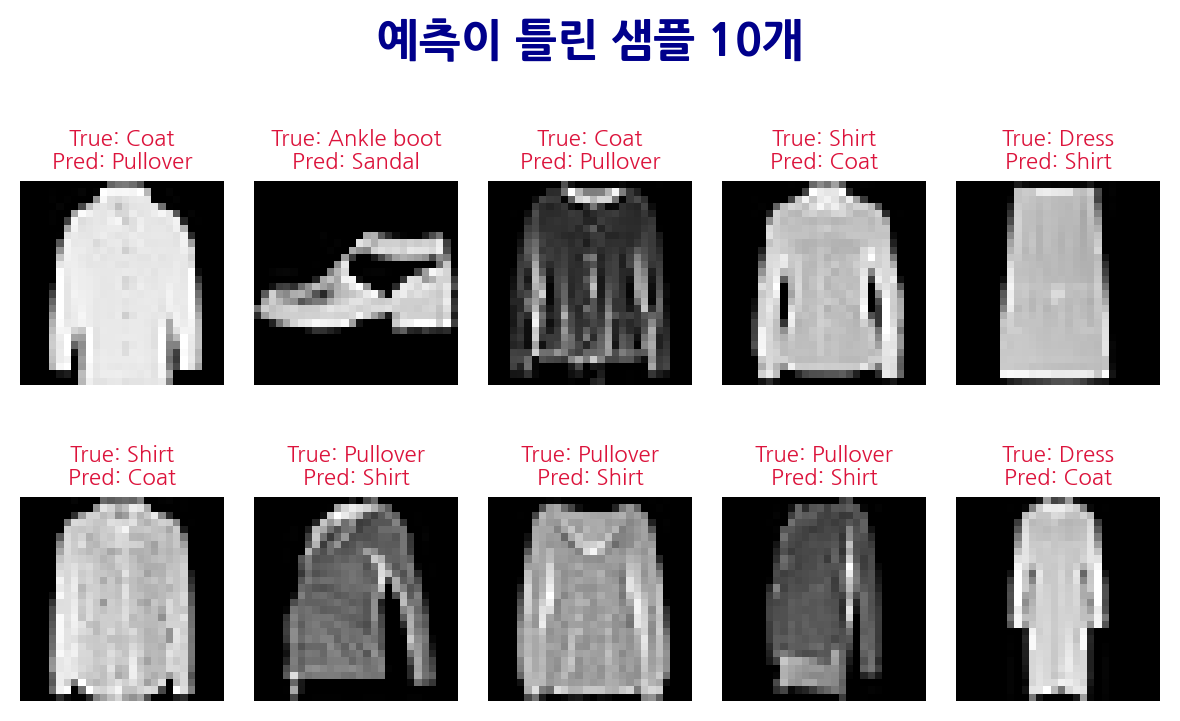

In [21]:
# 5 예측이 틀린 샘플 10개 시각화
incorrect_indices = np.where(y_pred_classes != y_test)[0]

plt.figure(figsize=(6, 4))
for i, idx in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred_classes[idx]]}",
              fontsize=8,       # 폰트 크기
              color='crimson',  # 폰트 색상
              # weight='bold',  # 굵기 (선택)
              pad=5)            # 타이틀과 이미지 사이 간격
    plt.axis('off')

plt.suptitle("예측이 틀린 샘플 10개", fontsize=16, color='darkblue', weight='bold')
plt.tight_layout()
plt.show()

## 8-9회차 기본 CNN 전체

CNN 모델 구조 요약:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7561 - loss: 0.6776 - val_accuracy: 0.8738 - val_loss: 0.3548
Epoch 2/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8820 - loss: 0.3288 - val_accuracy: 0.8852 - val_loss: 0.3122
Epoch 3/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8969 - loss: 0.2814 - val_accuracy: 0.8990 - val_loss: 0.2738
Epoch 4/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9071 - loss: 0.2504 - val_accuracy: 0.9077 - val_loss: 0.2604
Epoch 5/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9196 - loss: 0.2176 - val_accuracy: 0.9052 - val_loss: 0.2600
Epoch 6/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9290 - loss: 0.1926 - val_accuracy: 0.9087 - val_loss: 0.2514
Epoch 7/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9349 - loss: 0.1743 - val_accuracy: 0.9108 - val_loss: 0.2607
Epoch 8/20
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9381 - loss: 0.16

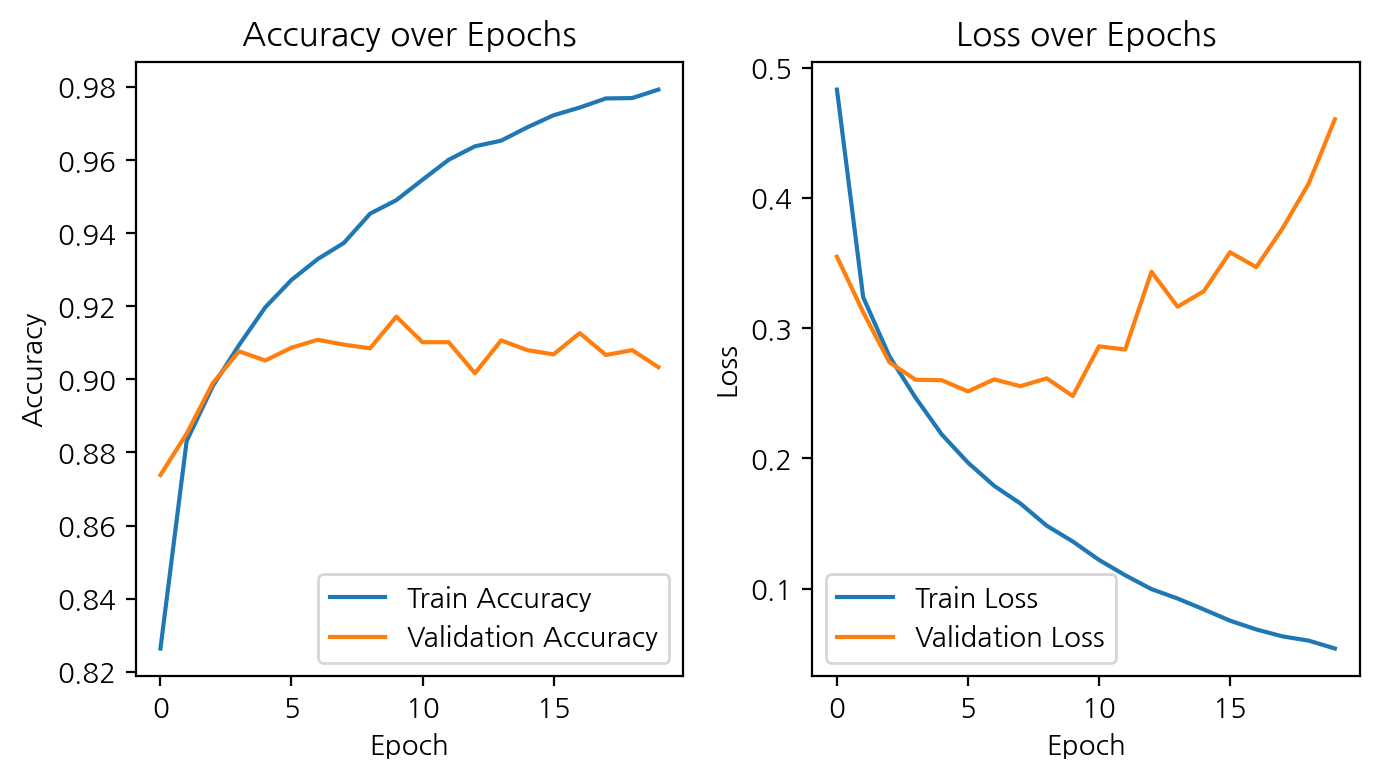

313/313 - 1s - 2ms/step - accuracy: 0.9026 - loss: 0.4868

[테스트 정확도]: 0.9026
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


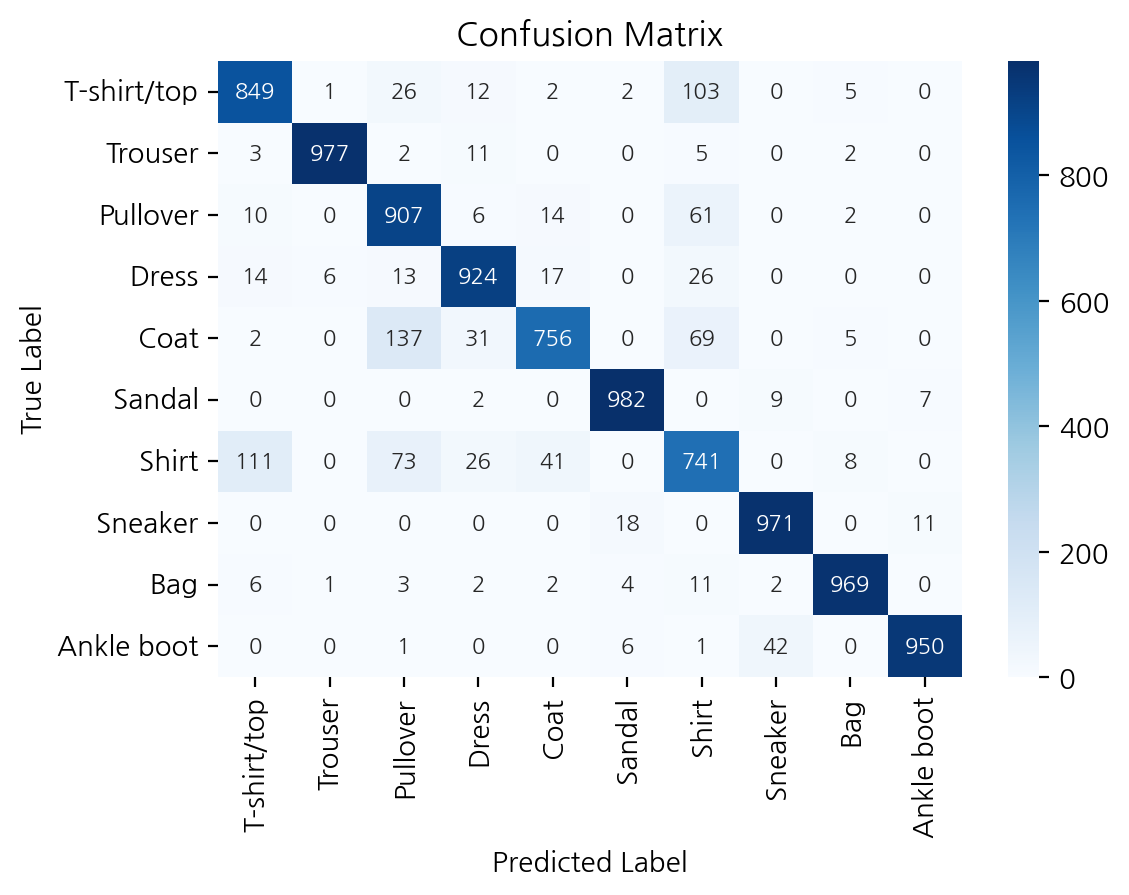

분류 리포트:
              precision    recall  f1-score   support

 T-shirt/top       0.85      0.85      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.78      0.91      0.84      1000
       Dress       0.91      0.92      0.92      1000
        Coat       0.91      0.76      0.83      1000
      Sandal       0.97      0.98      0.98      1000
       Shirt       0.73      0.74      0.73      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.97      0.97      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.91      0.90      0.90     10000
weighted avg       0.91      0.90      0.90     10000



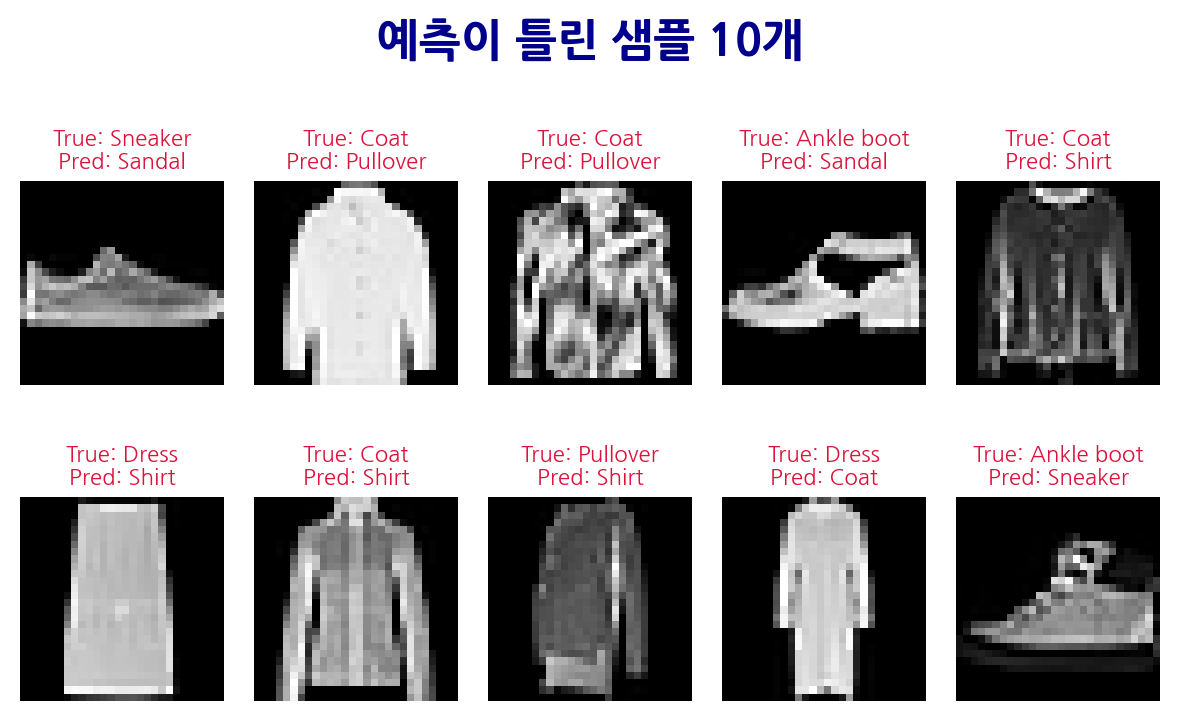

In [ ]:
# 필수 라이브러리 불러오기
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 텐서플로우 및 케라스 API 불러오기
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.metrics import confusion_matrix, classification_report

# 1 데이터 로딩 및 전처리
# Fashion MNIST 데이터셋 로딩 (훈련 데이터와 테스트 데이터 분리 제공됨)
fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# 픽셀 값을 0~255 정수에서 0~1 실수로 정규화 (모델 성능 향상)
x_train = x_train / 255.0
x_test = x_test / 255.0

# CNN 입력 형식에 맞게 채널 차원 추가: (28, 28) → (28, 28, 1)
x_train = x_train[..., np.newaxis]  # shape: (60000, 28, 28, 1)
x_test = x_test[..., np.newaxis]    # shape: (10000, 28, 28, 1)

# 클래스(레이블)에 해당하는 이름 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 2 CNN 모델 구성
# 순차적인 모델로 구성: Conv2D → MaxPooling → Conv2D → MaxPooling → Flatten → Dense → Output
model = models.Sequential([
    Input(shape=(28, 28, 1)),                      # 명시적 입력 레이어 추가
    layers.Conv2D(32, (3, 3), activation='relu'),  # 첫 번째 컨볼루션 층: 32개의 3x3 필터
    layers.MaxPooling2D((2, 2)),                   # 2x2 풀링으로 다운샘플링
    layers.Conv2D(64, (3, 3), activation='relu'),  # 두 번째 컨볼루션 층: 64개의 필터
    layers.MaxPooling2D((2, 2)),                   # 2x2 풀링
    layers.Flatten(),                              # 다차원 특징 맵을 1차원 벡터로 평탄화
    layers.Dense(64, activation='relu'),           # 은닉층: 64개의 뉴런
    layers.Dense(10, activation='softmax')         # 출력층: 10개의 클래스 확률
])

# 2-1 모델 구조 요약 출력
print("CNN 모델 구조 요약:")
model.summary()  # 각 층의 출력 형태 및 파라미터 수를 출력

# 3 모델 컴파일 및 학습
# 손실 함수: sparse_categorical_crossentropy (정수형 라벨 사용)
# 옵티마이저: Adam (적응적 학습률 사용)
# 평가지표: accuracy (정확도)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 학습: 훈련 데이터 중 10%를 검증 데이터로 사용 (validation_split=0.1)
history = model.fit(x_train, y_train, epochs=20, validation_split=0.1)

# 3-1 학습 정확도 및 손실 그래프 시각화
plt.figure(figsize=(7, 4))

# 정확도 변화 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')              # 훈련 정확도
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')    # 검증 정확도
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실값 변화 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')                     # 훈련 손실
plt.plot(history.history['val_loss'], label='Validation Loss')           # 검증 손실
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# 4 모델 평가 (테스트 데이터)
# 학습되지 않은 테스트 데이터로 모델 정확도 평가
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f'\n[테스트 정확도]: {test_acc:.4f}')

# 테스트 데이터에 대한 예측 수행
y_pred = model.predict(x_test)                        # softmax 확률 출력
y_pred_classes = np.argmax(y_pred, axis=1)            # 확률이 가장 높은 클래스 선택

# 4-1 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred_classes)         # 혼동 행렬 계산

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={'size': 8})  # ← 폰트 크기 조정
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# 4-2 분류 리포트 출력 (정확도, 정밀도, 재현율, F1-score)
print("분류 리포트:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))

# 5 예측이 틀린 샘플 10개 시각화
incorrect_indices = np.where(y_pred_classes != y_test)[0]

plt.figure(figsize=(6, 4))
for i, idx in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[idx].squeeze(), cmap='gray')
    plt.title(f"True: {class_names[y_test[idx]]}\nPred: {class_names[y_pred_classes[idx]]}",
              fontsize=8,          # 폰트 크기
              color='crimson',      # 폰트 색상
              # weight='bold',        # 굵기 (선택)
              pad=5)                # 타이틀과 이미지 사이 간격
    plt.axis('off')

plt.suptitle("예측이 틀린 샘플 10개", fontsize=16, color='darkblue', weight='bold')
plt.tight_layout()
plt.show()

## 종료